# Comparing ASCAT and insitu data from the ISMN

The International Soil Moisture Network is an international cooperation to establish and maintain a global in-situ soil moisture database. Find more information on the ISMN website: http://ismn.geo.tuwien.ac.at/

## 1. Data access

For this exercise, you need to download some ISMN in situ data to your computer. Before you are able to download the data, you have to create a free account. Then it might take some time until your account is confirmed and you have access to the restricted area.
<br><br>
As soon as your account is confirmed: Go to "Data Access" and download the data of the station Barnas from the SMOSMANIA network. Make sure you download only the data from this station, otherwise you will get large amounts of data that you might not need.

## 2. Introduction

This example program loops through all provided in situ stations that measure soil moisture with a depth between 0 and 0.1 m. It then finds the nearest ASCAT grid point and reads the ASCAT data. After temporal matching and scaling using linear CDF matching, it computes several metrics like the correlation coefficients (Pearson’s, Spearman’s and Kendall’s), Bias, RMSD as well as the [Nash–Sutcliffe model efficiency coefficient](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient).
<br><br>
For more information on the metrics, please go back to Exercise 3 - Error modelling.

## 3. Code

In [8]:
%matplotlib inline

In [12]:
import pytesmo.io.ismn.interface as ismn
import pytesmo.io.sat.ascat as ascat
import pytesmo.temporal_matching as temp_match
import pytesmo.scaling as scaling
import pytesmo.df_metrics as df_metrics
import pytesmo.metrics as metrics

import os
import matplotlib.pyplot as plt


ascat_folder = '../ASCAT_080_ssm_netcdf/'
ascat_grid_folder = '../ascat_grid/'

#init the ASCAT_SSM reader with the paths
 
ascat_SSM_reader = ascat.AscatH25_SSM(ascat_folder,ascat_grid_folder,
                                      include_in_df=['sm', 'sm_noise',
                                                     'ssf', 'proc_flag'])

After importing all required modules, the ASCAT SSM reader is initialized with the defined paths. Then, the paths to the ISMN data are set.
<br>**There, you have to insert the path to your downloaded ISMN data!**

In [13]:
# set path to ISMN data - insert your path here!
path_to_ismn_data = "/data/ISMN/SMOSMANIA/Barnas/"

The ISMN reader is initialized and then the data is read, looping through two for-loops. The looping is stopped after two stations to prevent the program from taking to much time to run.

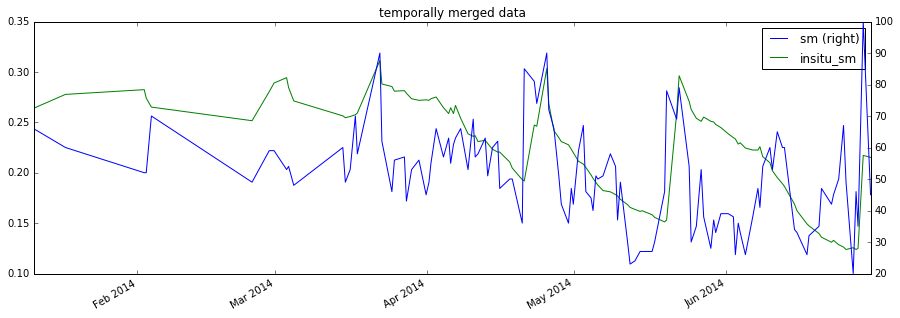

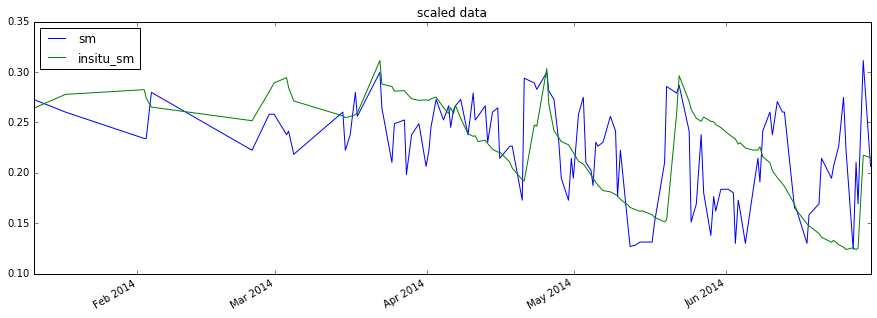

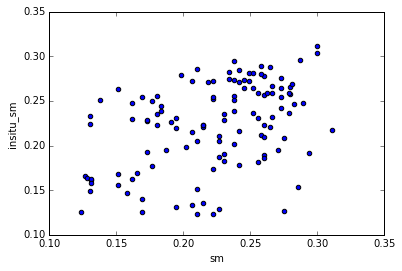

ISMN time series: SMOSMANIA Barnas 0.05 m - 0.05 m soil moisture measured with ThetaProbe-ML2X 
compared to
ASCAT time series gpi:2288223 lat:44.686 lon:4.100
Results:
(Pearsons_r(sm_and_insitu_sm=0.42863728682457364), p_value(sm_and_insitu_sm=1.038389404522722e-06))
Spearman's (rho,p_value) SpearmanrResult(correlation=0.41817969470055744, pvalue=2.0078326873814775e-06)
Kendalls's (tau,p_value) KendalltauResult(correlation=0.2822065613432006, pvalue=4.86789211247991e-06)
(Kendall_tau(sm_and_insitu_sm=0.2822065613432006), p_value(sm_and_insitu_sm=4.86789211247991e-06))
rmsd(sm_and_insitu_sm=0.05087831301234684)
Bias -0.000873789247285
Nash Sutcliffe -0.169703832338


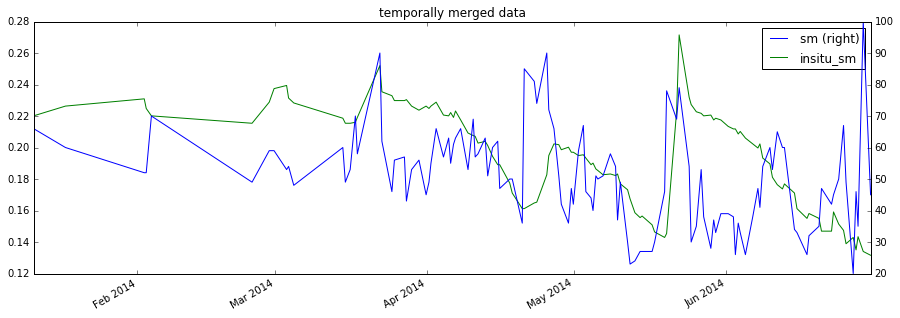

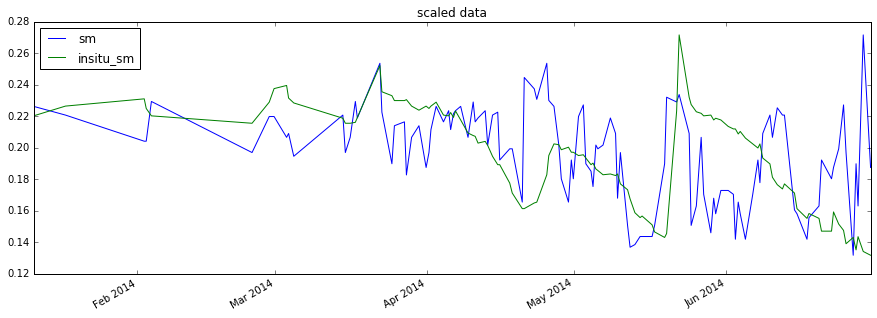

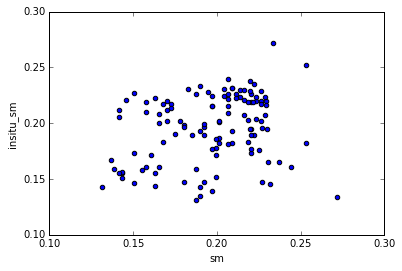

ISMN time series: SMOSMANIA Barnas 0.10 m - 0.10 m soil moisture measured with ThetaProbe-ML2X 
compared to
ASCAT time series gpi:2288223 lat:44.686 lon:4.100
Results:
(Pearsons_r(sm_and_insitu_sm=0.26553813220433392), p_value(sm_and_insitu_sm=0.0033766647861058984))
Spearman's (rho,p_value) SpearmanrResult(correlation=0.25711408100889016, pvalue=0.0045842133080270459)
Kendalls's (tau,p_value) KendalltauResult(correlation=0.16938613857606388, pvalue=0.0060834600584373467)
(Kendall_tau(sm_and_insitu_sm=0.16938613857606388), p_value(sm_and_insitu_sm=0.0060834600584373467))
rmsd(sm_and_insitu_sm=0.03613857333578737)
Bias 0.00064417835284
Nash Sutcliffe -0.501752826607


In [14]:
#Initialize reader
ISMN_reader = ismn.ISMN_Interface(path_to_ismn_data)

i = 0

label_ascat='sm'
label_insitu='insitu_sm'

#this loops through all stations that measure soil moisture
for station in ISMN_reader.stations_that_measure('soil moisture'):

    #this loops through all time series of this station that measure soil moisture
    #between 0 and 0.1 meters
    for ISMN_time_series in station.data_for_variable('soil moisture',min_depth=0,max_depth=0.1):

        ascat_time_series = ascat_SSM_reader.read_ssm(ISMN_time_series.longitude,
                                                      ISMN_time_series.latitude,
                                                      mask_ssf=True,
                                                      mask_frozen_prob = 5,
                                                      mask_snow_prob = 5)


        #drop nan values before doing any matching
        ascat_time_series.data = ascat_time_series.data.dropna()

        ISMN_time_series.data = ISMN_time_series.data.dropna()

        #rename the soil moisture column in ISMN_time_series.data to insitu_sm
        #to clearly differentiate the time series when they are plotted together
        ISMN_time_series.data.rename(columns={'soil moisture':label_insitu},inplace=True)

        #get ISMN data that was observerd within +- 1 hour(1/24. day) of the ASCAT observation
        #do not include those indexes where no observation was found
        matched_data = temp_match.matching(ascat_time_series.data,ISMN_time_series.data,
                                                window=1/24.)
        #matched ISMN data is now a dataframe with the same datetime index
        #as ascat_time_series.data and the nearest insitu observation

        #continue only with relevant columns
        matched_data = matched_data[[label_ascat,label_insitu]]

        #the plot shows that ISMN and ASCAT are observed in different units
        matched_data.plot(figsize=(15,5),secondary_y=[label_ascat],
                          title='temporally merged data')
        plt.show()

        #this takes the matched_data DataFrame and scales all columns to the
        #column with the given reference_index, in this case in situ
        scaled_data = scaling.scale(matched_data, method='lin_cdf_match',
                                         reference_index=1)

        #now the scaled ascat data and insitu_sm are in the same space
        scaled_data.plot(figsize=(15,5), title='scaled data')
        plt.show()

        plt.scatter(scaled_data[label_ascat].values,scaled_data[label_insitu].values)
        plt.xlabel(label_ascat)
        plt.ylabel(label_insitu)
        plt.show()

        #calculate correlation coefficients, RMSD, bias, Nash Sutcliffe
        x, y = scaled_data[label_ascat].values, scaled_data[label_insitu].values

        print "ISMN time series:",ISMN_time_series
        print "compared to"
        print ascat_time_series
        print "Results:"

        #df_metrics takes a DataFrame as input and automatically
        #calculates the metric on all combinations of columns
        #returns a named tuple for easy printing
        print df_metrics.pearsonr(scaled_data)
        print "Spearman's (rho,p_value)", metrics.spearmanr(x, y)
        print "Kendalls's (tau,p_value)", metrics.kendalltau(x, y)
        print df_metrics.kendalltau(scaled_data)
        print df_metrics.rmsd(scaled_data)
        print "Bias", metrics.bias(x, y)
        print "Nash Sutcliffe", metrics.nash_sutcliffe(x, y)


    i += 1

    #only show the first 2 stations, otherwise this program would run a long time
    #and produce a lot of plots
    if i >= 2:
        break